## NFW Profile Model for Red Low Surface Brightness Galaxies (Source Redshift Distribution)

This notebook walks through the process of generating a model composed of two NFW profiles to represent the tangential shear measurements for the red sample of the low surface brightness galaxy catalog. We use two NFW profiles to indicate the subhalo term and the host halo term of the measurements. In particular, we compare the use of a distribution of source redshifts to a single, fixed source redshift. We rely on [colossus](https://bdiemer.bitbucket.io/colossus/cosmology_cosmology.html) for our base cosmology and [profiley](https://github.com/cristobal-sifon/profiley) to implement the NFW profiles. 

In [50]:
#Loading packages
from __future__ import print_function 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import twopoint
from profiley.nfw import TNFW, NFW
import scipy.stats as stats
from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology('planck15');
from astropy.cosmology import Planck15
from astropy import constants as const
import twopoint
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

### Measurements

We load in the red LSBG measurements (calculated using [TreeCorr](https://rmjarvis.github.io/TreeCorr/_build/html/index.html)) found in the data section of this repository. Theta_red represents the angular scales of the measurements, xi_red indicates the shear signal, error_red stands for the shot noise, and err_jk_red represents the error derived from the jackknife covariance. We conduct all of our modeling using the red galaxy sample, as this sample produces the greatest shear signal. The other galaxy samples can be found in the data section for additional testing. 

In [51]:
#Loading measurements
#Theta represents the angular scales of the measurements, xi represents the lensing signal, the error represents the shot noise, err_jk indicates the jackknife covariance, and the cross term represents the lensing B-mode shear (used as a systematics test)
theta_red, xi_red, error_red, cross_term_red = np.loadtxt('../data/gt_LSBG_combined_sources_scales_3_red_ran', unpack=True)
theta_red, xi_red, err_jk_red, cross_term_red = np.loadtxt('../data/gt_LSBG_jackknife_combined_sources_scales_3_red_ran', unpack=True)

#Defining covariance
cov = np.loadtxt('../data/jkcov_gt_LSBG_combined_sources_scales_3_red_ran')



We define two functions to calculate the $\chi^2$ between the model and the measurements and the $\Delta \chi^2$ between two models. 

In [52]:
#Chi2 function (quantitative comparison between model and measurements)
def chi2(cov, model, measurements):
    invcov = np.abs(np.linalg.inv(cov))
    chi2 = np.dot((measurements-model).T, np.dot(invcov, (measurements-model)))
    return chi2


In [53]:
#Delta chi2 function (comparison between two models)
def deltachi2(cov, model, measurements):
    invcov = np.abs(np.linalg.inv(cov))
    INVCOV = np.matrix(invcov)
    diff = np.matrix((model).T[0]-(measurements).T[0])
    deltachi2 = diff*INVCOV*diff.T
    return deltachi2

### Source Redshift Distribution

We load in the source redshift catalog. The catalog presents the source redshifts divided in four tomographic bins, which we weight by galaxy count, sum, and normalize to produce our source redshift distribution. We plot each of the weighted redshift bins and compare to the total distribution. 

0.6297101017079711


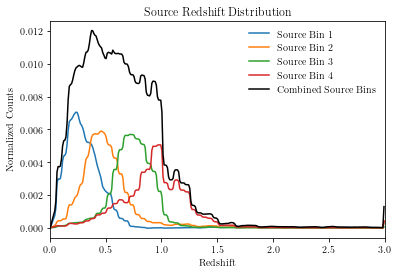

In [54]:
#Finding mean source redshift 
T = twopoint.TwoPointFile.from_fits('../data/2pt_NG_final_2ptunblind_02_24_21_wnz_redmagic_covupdate.fits') #Loading source redshift file
T.kernels[0].name
nzs = (T.kernels[0].nzs) 
zsbin = (T.kernels[0].z)

#Weighting each of the source redshift bins by the galaxy count
nzs_count = 24940465+25280405+24891859+25091297 #galaxy count for bins 1-4
b1_weighted = (nzs[0]*24940465)/nzs_count
b2_weighted = (nzs[1]*25280405)/nzs_count
b3_weighted = (nzs[2]*24891859)/nzs_count
b4_weighted = (nzs[3]*25091297)/nzs_count

#Plotting the weighted source redshift bins
plt.plot(zsbin, b1_weighted, label= 'Source Bin 1')
plt.plot(zsbin, b2_weighted, label= 'Source Bin 2')
plt.plot(zsbin, b3_weighted, label= 'Source Bin 3')
plt.plot(zsbin, b4_weighted, label = 'Source Bin 4')
nzs_weighted = np.array([b1_weighted, b2_weighted, b3_weighted, b4_weighted])

A= np.trapz(np.sum(nzs_weighted, axis=0)) #Defining the normalization factor for the combined weighted redshift bins
norm_test = np.trapz(np.sum(nzs_weighted, axis=0)/A) #This should equal 1
zsdist_norm = np.sum(nzs_weighted, axis=0)/A #Defining normalized source redshift distribution
z_mean_s = np.trapz(zsbin*zsdist_norm) #Finding the mean of the source redshift distribution
plt.plot(zsbin, zsdist_norm, color='black', label='Combined Source Bins') #Plotting the single-binned, normalized source redshift
print(z_mean_s)
plt.xlim(0, 3.0)
plt.legend(frameon=False)
plt.xlabel('Redshift')
plt.ylabel('Normalized Counts')
plt.title('Source Redshift Distribution')
plt.show()

The length of the redshift distribution must be the same as the length of the lens distribution and the measurements. As such, we must modify the source redshift distribution to obtain an array of size (25). We skip every 12 points of the (300) sized array to follow the shape of the distribution and achieve the correct size. This modified distribution is plotted below.

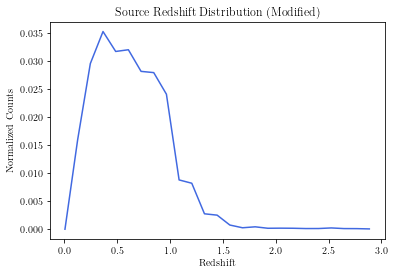

1.0


In [55]:
#Plot of modified source distribution (sized to fit model, for 25 points)
plt.plot(zsbin[:300][::12], (np.sum(nzs_weighted, axis=0)[:300][::12]/(np.trapz(np.sum(nzs, axis=0)[:300][::12]))), color='royalblue', label='Modified Source Redshift Distribution')
plt.xlabel('Redshift')
plt.ylabel('Normalized Counts')
plt.title('Source Redshift Distribution (Modified)')
plt.show()
#Test that this distribution is properly normalized:
print(np.trapz(np.sum(nzs_weighted, axis=0)[:300][::12]/(np.trapz(np.sum(nzs_weighted, axis=0)[:300][::12]))))
#Yes, this distribution is normalized
#Question- this looks like a much higher peak than the full normalized distribution. I think it's because with fewer points it's weighted more strongly towards the lower redshifts.

### Defining Parameters

We define the parameters for both the fixed source redshift and source redshift distribution models. The NFW profile parameters include the lens redshift, the concentration (fixed at 2.0), and the mass. We require the source redshift  to produce the $\Sigma_{\mathrm{crit}}$, a geometrical lensing factor that varies with the characteristics of the lensing system. Our mass terms and our mean lens redshift come from posteriors obtained with an MCMC. We build a gaussian around this mean lens redshift to construct our distribution. Our scales and our offset term (used to define the offset of the host halo profile) come from our measurements. 

In [56]:
#Defining parameters for fixed source redshift model
zl = 13.2e-3 #lens redshift from posterior of MCMC
zs = z_mean_s  #Fixed source redshift
mass_term_1 = 9.9e10 #subhalo mass from checking chi2
mass_term_2 = 12.2e14 #host halo mass from posterior of MCMC

In [57]:
#Defining parameters for source redshift distribution model
zl_zsdist = 8.5e-3 #Lens redshift for source redshift distribution model from posterior of MCMC
mass_term_1_zsdist = 9.9e10 #Subhalo mass for source redshift distribution model, found by checking chi2
mass_term_2_zsdist = 16.9e14 #Host halo mass for source redshift distribution model from posterior of MCMC

In [58]:
#Defining parameters for both models
zl_sigma = 0.01 #width of lens redshift distribution
concentration = 2.
theta_arcmin = np.geomspace(0.25, 1000, 25) #Scales for model
theta_rad = theta_arcmin/60*np.pi/180 #Change to radians
offset_rad = 14/60*np.pi/180 #Offset distance
da = Planck15.angular_diameter_distance(zl)

### Model

We compare two models- the model using a source redshift distribution and the model using a fixed source redshift. For the source redshift distribution model, we first construct a modified version of the source redshift distribution with size (25) and normalize. We build a Gaussian distribution for the lens redshift, normalize,and use the range of possible lens redshifts to convert our angular scales to physical scales. We then construct the subhalo NFW term using the first mass term, the concentration, and the range of possible lens redshifts. We use the range of source redshifts to create the $\Sigma_\mathrm{crit}$ term. We calculate the excess surface density and the tangential shear for each of the 25 NFW profiles and integrate all of these terms over the normalized lens redshift and source redshift distribution. We repeat this process for the host halo term, but we alter the scales by a normalized offset distribution. We sum these two integrated profiles to find our total model.

For the fixed source redshift, we follow the same process, save that we do not construct a source redshift distribution, we calculate $\Sigma_\mathrm{crit}$ only using the mean source redshift, and we only integrate over the normalized lens redshift distribution. 

In [59]:
#Source redshift distribution model
def total_model_zsdist(mass_term1, mass_term2, zs_mean, zl_mean, zl_sigma, theta_rad):
    zsrange = zsbin[:300][::12] #Range of source redshift distribution, must have 25 points 
    zsdist = np.sum(nzs_weighted, axis=0)[:300][::12] #Building up source redshift distribution
    A_zs = np.trapz(zsdist) #Normalization factor
    zsdist_norm = zsdist/A_zs #Normalized source redshift distribution
    
    zlrange = np.linspace(zl_mean - 1*zl_sigma, zl_mean + 3*zl_sigma, 25) #Lens redshift range
    zldist = stats.norm.pdf(zlrange, zl_mean, zl_sigma) #Gaussian lens redshift distribution
    A_zl = np.trapz(zldist) #Normalization factor for lens redshift
    zldist_norm = zldist/A_zl #Normalized lens redshift distribution 
    
    da = Planck15.angular_diameter_distance(zlrange) #Conversion from angular scales to physical scales based on redshift
    r_mpc = da*theta_rad
    nfw_term1 = NFW(mass_term1, concentration, zlrange) #Subhalo NFW
    print(nfw_term1)
    sigma_crit = nfw_term1.sigma_crit([zsrange]) #Sigma crit calculation
    esd = nfw_term1.projected_excess(r_mpc) #Excess surface density
    gt_term1 = esd/sigma_crit #Shear model for 25 NFW profiles
    I_calc_term1 = np.reshape((np.trapz(esd*zldist_norm)*np.trapz((1/sigma_crit)*(zsdist_norm))), (25,1)) #Integrated model over 25 NFW profiles, with normalized lens and source redshift distributions
    
    da_roff = Planck15.angular_diameter_distance(zl_mean) #Physical distance for offset
    mean_roff = np.array(offset_rad*da_roff) #Building offset distribution
    sigma_roff = np.sqrt(mean_roff)
    r_off_range = np.linspace(0, mean_roff+2*sigma_roff, 25)
    r_off_dist = stats.norm.pdf(r_off_range, mean_roff, sigma_roff)
    A_off = np.trapz(r_off_dist)
    A_off_norm = r_off_dist/A_off #Normalized offset distribution
    nfw_term2 = NFW(mass_term2, concentration, zlrange) #Host halo NFW
    print(nfw_term2)
    sigma_crit_term2 = nfw_term2.sigma_crit([zsrange]) #Host halo sigma crit
    esd_off_dist = nfw_term2.offset_projected_excess(np.array(r_mpc), np.array(r_off_dist)) #Excess surface density for offset NFW
    gt_term2 = esd_off_dist[0]/sigma_crit_term2 #Shear model for 25 NFW profiles
    I_calc_term2 = np.reshape((np.trapz(esd_off_dist[0]*A_off_norm*zldist_norm)*np.trapz((1/sigma_crit_term2)*(zsdist_norm))), (25,1)) #Integrated model with offset over 25 NFW profiles, with normalized lens and source redshift distributions
    
    total_model = I_calc_term1 + I_calc_term2 #Total model
    return total_model, I_calc_term1, I_calc_term2


In [60]:
#Model for a fixed source redshift
def total_model_zsfix(mass_term1, mass_term2, zs_mean, zl_mean, zl_sigma, theta_rad):
    zlrange = np.linspace(zl_mean - 1*zl_sigma, zl_mean + 3*zl_sigma, 25) #Lens redshift range
    zldist = stats.norm.pdf(zlrange, zl_mean, zl_sigma) #Gaussian lens redshift distribution
    A_zl = np.trapz(zldist) #Normalization factor for lens redshift
    zldist_norm = zldist/A_zl #Normalized lens redshift distribution 
    
    da = Planck15.angular_diameter_distance(zlrange) #Conversion from angular scales to physical scales based on redshift
    r_mpc = da*theta_rad
    nfw_term1 = NFW(mass_term1, concentration, zlrange) #Subhalo NFW
    print(nfw_term1)
    sigma_crit = nfw_term1.sigma_crit([zs_mean]) #Sigma crit for a fixed source redshift
    esd = nfw_term1.projected_excess(r_mpc) #Excess surface density
    gt_term1 = esd/sigma_crit #Shear model for 25 NFW profiles
    I_calc_term1 = np.reshape((np.trapz(gt_term1*zldist_norm)), (25,1)) #Integrated model with only lens redshift distribution
   
    da_roff = Planck15.angular_diameter_distance(zl_mean) #Conversion of offset to physical distance
    mean_roff = np.array(offset_rad*da_roff) #Building offset distribution
    sigma_roff = np.sqrt(mean_roff)
    r_off_range = np.linspace(0, mean_roff+2*sigma_roff, 25)
    r_off_dist = stats.norm.pdf(r_off_range, mean_roff, sigma_roff)
    A_off = np.trapz(r_off_dist)
    A_off_norm = r_off_dist/A_off #Offset normalized distribution
    nfw_term2 = NFW(mass_term2, concentration, zlrange) #Host halo NFW
    print(nfw_term2)
    sigma_crit_term2 = nfw_term2.sigma_crit([zs_mean]) #Host halo NFW with fixed source redshift
    esd_off_dist = nfw_term2.offset_projected_excess(np.array(r_mpc), np.array(r_off_dist)) #Excess surface density with offset 
    gt_term2 = esd_off_dist[0]/sigma_crit_term2 #Shear model for 25 offset NFW profiles
    I_calc_term2 = np.reshape((np.trapz(gt_term2*A_off_norm*zldist_norm)), (25,1)) #Integrated model with offset and only lens redshift distribution
    
    total_model = I_calc_term1 + I_calc_term2 #Total model
    return total_model, I_calc_term1, I_calc_term2


In [61]:
#Calling function for source redshift distribution
total_model_dist = total_model_zsdist(mass_term_1_zsdist, mass_term_2_zsdist, zs, zl_zsdist, zl_sigma, theta_rad)

NFW profile object containing 25 profiles
shape: (25,)
  overdensity: 500c
  log10 mass/Msun = 11.00
  concentration = 2.00
  redshift range = -0.00-0.04
NFW profile object containing 25 profiles
shape: (25,)
  overdensity: 500c
  log10 mass/Msun = 15.23
  concentration = 2.00
  redshift range = -0.00-0.04


In [62]:
#Calling function for fixed source redshift
total_model_zs_single = total_model_zsfix(mass_term_1, mass_term_2, zs, zl, zl_sigma, theta_rad)

NFW profile object containing 25 profiles
shape: (25,)
  overdensity: 500c
  log10 mass/Msun = 11.00
  concentration = 2.00
  redshift range = 0.00-0.04
NFW profile object containing 25 profiles
shape: (25,)
  overdensity: 500c
  log10 mass/Msun = 15.09
  concentration = 2.00
  redshift range = 0.00-0.04


### Plot

We compare both models to our red LSBG shear measurements. Note that the models are functions of physical scales (R), while the measurements are functions of angular scales ($\theta$). The errorbars on the measurements come from the jackknife covariance. 

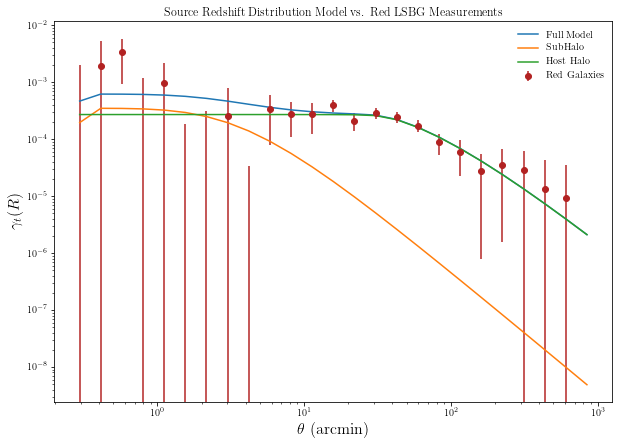

In [63]:
#Plot comparing measurements to source redshift distribution model
fig, ax = plt.subplots(figsize=(10,7), ncols=1)
plt.errorbar(theta_red, xi_red, err_jk_red, fmt="o", color="firebrick", label="Red Galaxies")
ax.plot(theta, total_model_dist[0], label = 'Full Model')
ax.plot(theta, total_model_dist[1], label = 'SubHalo')
ax.plot(theta, total_model_dist[2], label = 'Host Halo')
ax.set_ylabel(r'$\gamma_t(R)$', fontsize=16)
ax.set_xlabel('$\\theta$ (arcmin)', fontsize=16)
ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_yscale('log')
plt.title('Source Redshift Distribution Model vs. Red LSBG Measurements')
plt.show()

We include the $\chi^2$ calculations between the source redshift distribution model and the red LSBG shear measurements.

In [64]:
#Chi2 calculation for source redshift distribution model
chi2_total = chi2(cov, total_model_dist[0], np.reshape(xi_red, (25,1)))
print(chi2_total)

[[35.23262383]]


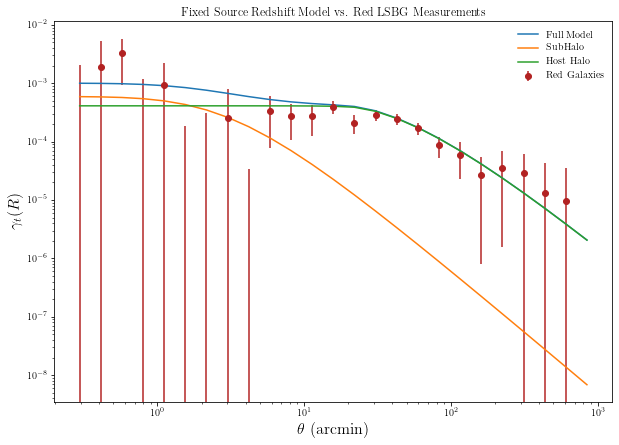

In [65]:
#Plot for fixed source redshift model
fig, ax = plt.subplots(figsize=(10,7), ncols=1)
plt.errorbar(theta_red, xi_red, err_jk_red, fmt="o", color="firebrick", label="Red Galaxies")
ax.plot(theta, total_model_zs_single[0], label = 'Full Model')
ax.plot(theta, total_model_zs_single[1], label = 'SubHalo')
ax.plot(theta, total_model_zs_single[2], label = 'Host Halo')
ax.set_ylabel(r'$\gamma_t(R)$', fontsize=16)
ax.set_xlabel('$\\theta$ (arcmin)', fontsize=16)
ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_yscale('log')
plt.title('Fixed Source Redshift Model vs. Red LSBG Measurements')
plt.show()


In [66]:
#Chi2 for fixed source redshift model
chi2_total_zsfix = chi2(cov, total_model_zs_single[0], np.reshape(xi_red, (25,1)))
print(chi2_total_zsfix)

[[109.02765584]]


We calculate the difference between the two models using the $\Delta \chi^2$.

In [67]:
#Deltachi2 between fixed source redshift and source redshift distribution models
delta_dist = deltachi2(cov, total_model_zs_single[0], total_model_dist[0])
print(delta_dist)

[[46.11739789]]


We directly compare the two models to each other and the red LSBG shear measurements. 

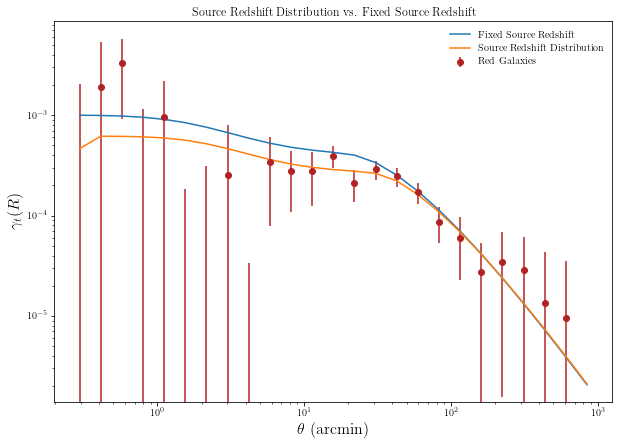

In [68]:
#Overlaid plot between fixed source redshift and source redshift distribution models
fig, ax = plt.subplots(figsize=(10,7), ncols=1)
plt.errorbar(theta_red, xi_red, err_jk_red, fmt="o", color="firebrick", label="Red Galaxies")
ax.plot(theta, total_model_zs_single[0], label = 'Fixed Source Redshift')
ax.plot(theta, total_model_dist[0], label = 'Source Redshift Distribution')
ax.set_ylabel(r'$\gamma_t(R)$', fontsize=16)
ax.set_xlabel('$\\theta$ (arcmin)', fontsize=16)
ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_yscale('log')
plt.title('Source Redshift Distribution vs. Fixed Source Redshift')
plt.show()